# PL12 .- HYBRID QUANTUM NEURAL NETWORKS

En este notebook, vamos a mostrar cómo se pueden construir redes neuronales cuánticas híbridas integrando *pennylane* con *Keras*.

Comenzamos importando las librerías necesarias y fijando las semillas de los generadores aleatorios.

In [1]:
!pip install pennylane
!pip install tensorflow==2.15
!pip install silence_tensorflow

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pennylane as qml
import random
import os

os.environ['PYTHONHASHSEED']='0'

rs = 12345  # Semilla aleatoria

random.seed(rs)
np.random.seed(rs)
tf.random.set_seed(rs)

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: 

Creamos un conjunto de datos sencillo y los dividimos en entrenamiento y test.

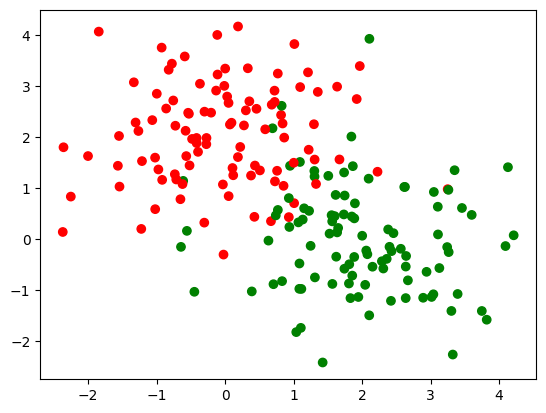

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, centers = [[0,2],[2,0]], random_state = rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=rs)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=matplotlib.colors.ListedColormap(["red","green"]));

Como vamos a usar *angle embedding*, escalamos los datos al intervalo $[0,\pi]$.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,np.pi))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## REDES NEURONALES HÍBRIDAS

Cuando tenemos una capa de Keras que es, en realidad, un circuito cuántico, se abre la posibilidad de combinar capas clásicas y cuánticas: es lo que llamamos redes neuronales híbridas.

Para crearlas, podemos simplemente usar el modelo secuencial de Keras y combinar capas de un tipo y de otro, teniendo en cuenta el número de entradas y salidas que tiene cada una. Una ventaja de este enfoque es que podemos fácilmente reducir el número de atributos con una primera capa clásica.

Nótese que en el circuito cuántico ahora devolvemos tantos valores como qubits hay.

Empezamos con una sola repetición de la forma variacional en la capa cuántica.

In [4]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim=2))
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [5]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 1s 257ms/step - loss: 0.7961 - accuracy: 0.2891 - val_loss: 0.7163 - val_accuracy: 0.4062
Epoch 2/100
4/4 [==============================] - 1s 360ms/step - loss: 0.7205 - accuracy: 0.3047 - val_loss: 0.6930 - val_accuracy: 0.4375
Epoch 3/100
4/4 [==============================] - 1s 336ms/step - loss: 0.6979 - accuracy: 0.4609 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 1s 299ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 1s 239ms/step - loss: 0.6951 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 2s 566ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/100
4/4 [==============================] - 3s 712ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 8/100
4

2/2 [==============================] - 0s 82ms/step - loss: 0.1111 - accuracy: 0.9750


[0.11114094406366348, 0.9750000238418579]

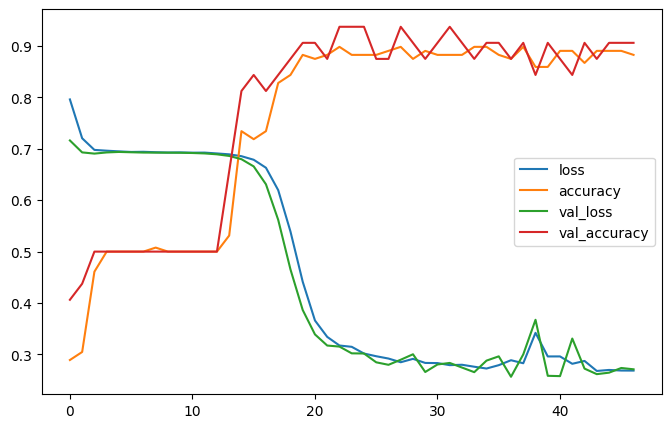

In [6]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 keras_layer (KerasLayer)    (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ahora, usamos dos repeticiones de la forma variacional.

In [8]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim=2))
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 1s 237ms/step - loss: 0.7462 - accuracy: 0.5000 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 1s 188ms/step - loss: 0.7076 - accuracy: 0.3906 - val_loss: 0.6974 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 1s 181ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6827 - val_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 1s 192ms/step - loss: 0.6722 - accuracy: 0.5312 - val_loss: 0.6499 - val_accuracy: 0.7500
Epoch 5/100
4/4 [==============================] - 1s 190ms/step - loss: 0.6460 - accuracy: 0.8359 - val_loss: 0.6171 - val_accuracy: 0.8750
Epoch 6/100
4/4 [==============================] - 1s 187ms/step - loss: 0.5929 - accuracy: 0.8828 - val_loss: 0.5647 - val_accuracy: 0.8750
Epoch 7/100
4/4 [==============================] - 1s 223ms/step - loss: 0.5466 - accuracy: 0.8828 - val_loss: 0.5169 - val_accuracy: 0.8125
Epoch 8/100
4

2/2 [==============================] - 0s 66ms/step - loss: 0.1158 - accuracy: 0.9750


[0.11583741009235382, 0.9750000238418579]

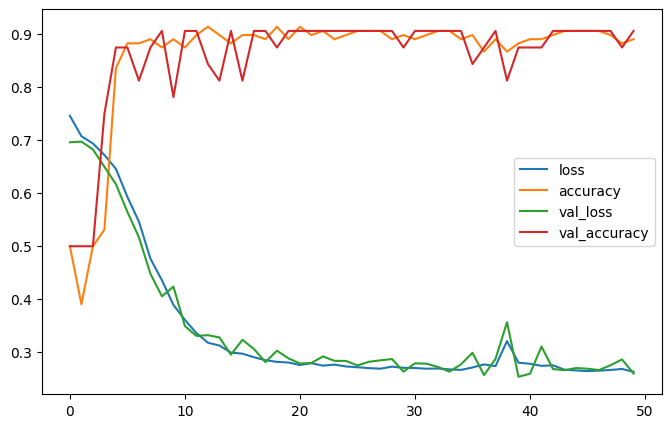

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## EJERCICIO

Crear una red híbrida para un problema de clasificación binaria con 50 variables de entrada (por ejemplo, con *make_classification*, de *SciKit Learn*). Usar una capa cuántica de 8 qubits.

In [37]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=20000, n_features = 50, n_informative = 10, n_classes = 2, random_state = rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=rs)

In [38]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim=50))
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

Epoch 1/100
400/400 [==============================] - 319s 799ms/step - loss: 0.6219 - accuracy: 0.6481 - val_loss: 0.6115 - val_accuracy: 0.6488
Epoch 2/100
400/400 [==============================] - 302s 753ms/step - loss: 0.6123 - accuracy: 0.6643 - val_loss: 0.6087 - val_accuracy: 0.6722
Epoch 3/100
400/400 [==============================] - 298s 745ms/step - loss: 0.6133 - accuracy: 0.6619 - val_loss: 0.6192 - val_accuracy: 0.6466
Epoch 4/100
400/400 [==============================] - 309s 774ms/step - loss: 0.6047 - accuracy: 0.6796 - val_loss: 0.5945 - val_accuracy: 0.6956
Epoch 5/100
400/400 [==============================] - 308s 770ms/step - loss: 0.5975 - accuracy: 0.6853 - val_loss: 0.5893 - val_accuracy: 0.6900
Epoch 6/100
400/400 [==============================] - 310s 776ms/step - loss: 0.5957 - accuracy: 0.6912 - val_loss: 0.5907 - val_accuracy: 0.6866
Epoch 7/100
400/400 [==============================] - 306s 765ms/step - loss: 0.5968 - accuracy: 0.6888 - val_loss: 0

[0.5673221349716187, 0.7179999947547913]

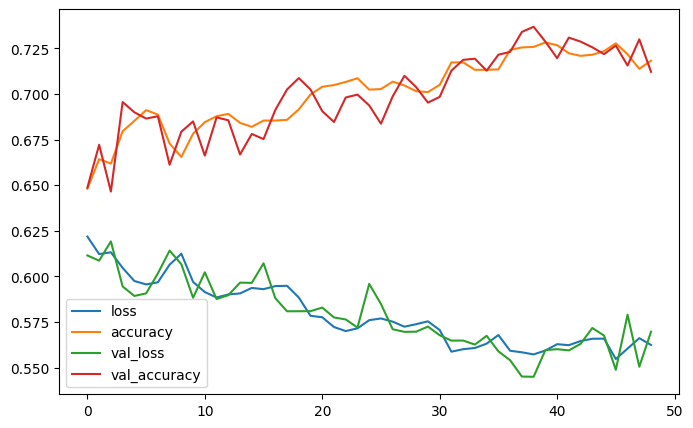

In [39]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping_cb])

pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [40]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 408       
                                                                 
 keras_layer_10 (KerasLayer  (None, 8)                 48        
 )                                                               
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
